Code for analysing sailor dataset

In [1]:
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import get_max_intensity_for_dataset, filter_on_intensity_and_add_data
from utils.model_utils import train_and_eval
from torch import nn
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [2]:
from utils.datahandling_utils import createImageIndexCSV

image_data = createImageIndexCSV("D:/sailor_DCE/", force=False,
                                 result_file_path="sailor_data_indices.csv")
mca_labels = pd.read_excel('sailor_mca_labels.xlsx')

# Remove patients with artefacts and missing mca
for p in [3, 5, 7, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 24, 25]:
    mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == p].index)
filtered_image_data = image_data[image_data['Patient'].isin(
    mca_labels['Patient'])]
mca_labels = pd.melt(mca_labels, id_vars=[
                     'Patient', 'Series'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Series', 'Slice'])


In [3]:
intensities = get_max_intensity_for_dataset(
    filtered_image_data, path='sailor_intensities.csv')


In [4]:
data = filter_on_intensity_and_add_data(
    filtered_image_data, mca_labels, intensities, 0)


In [5]:
from models.dense_net_torch import DenseNet
torch.manual_seed(SEED)
model = DenseNet(growth_rate=15, num_init_features=28,
                 bn_size=3, drop_rate=0.1, num_classes=1)
print(
    f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model.load_state_dict(torch.load('Model_crop_128_50.pt'))
model = model.to(device)
model.eval()


Total number of trainable parameters 1203409


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 28, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(28, 45, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(45, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [75]:
from operator import itemgetter
from models.mouridsen import get_AIF_KMeans
# from utils.datahandling_utils import crop_image

pred_type = ["single", "sigmoid", "all", "global"]


def get_MCA_prediction(model, data: pd.DataFrame, intensities: np.array, device: str, crop: float, pred_type: str):
    model.eval()
    patient = np.unique(data['Patient'])[0]
    series_idx = np.unique(data['Series'])[0]
    volume = int(np.squeeze(intensities[np.where(
        (intensities[:, 0] == patient) & (intensities[:, 1] == series_idx))[0]])[2])
    slices = data.loc[(data['Patient'] == patient) &
                      (data['Volume'] == volume)].copy()
    slice_preds = []
    info = {}
    for i, (_, slice) in enumerate(slices.iterrows()):
        slice_num = slice['Slice']
        image = pdc.dcmread(slice['ImagePath'])
        if i == 3:
            info['FA'] = image.FlipAngle
            info['TR'] = image.RepetitionTime
        image = crop_image(image.pixel_array, crop)
        image = image/np.max(image)
        image = np.expand_dims(image, axis=(0, 1))
        image = torch.tensor(image, dtype=torch.float).to(device)
        pred = torch.sigmoid(model(image)).item()
        if pred >= 0.5:
            slice_preds.append((slice_num, pred))
    if pred_type == "single":
        slice_preds = sorted(slice_preds, key=itemgetter(0), reverse=True)
        idx = len(slice_preds) // 2
        return [slice_preds[idx][0]], info
    elif pred_type == "sigmoid":
        slice_preds = sorted(slice_preds, key=itemgetter(1), reverse=True)
        return [slice_preds[0][0]], info
    return [i[0] for i in slice_preds], info


def filter_slices_on_mca_prediction(data, patient_num: int, mca_slices: list, crop=1) -> dict:
    images = {}
    for slice_idx in mca_slices:
        slice_paths = data[(data['Patient'] == patient_num)
                           & (data['Slice'] == slice_idx)]
        slice_paths = slice_paths.sort_values(
            ['Patient', 'Series', 'Volume', 'Slice'], ignore_index=True)
        image = []
        for path in slice_paths['ImagePath']:
            image.append(pdc.read_file(path).pixel_array)
        images[slice_idx] = crop_image(np.array(image), crop)
    return images


def extract_AIF_mouridsen(images: dict, series_idx: int, SEED: int, visualize: bool, pred_type: str) -> dict:
    curves = {}
    if pred_type == 'global':
        image = np.stack(images.values())
        curves_coords = get_AIF_KMeans(
            image, SEED, min_voxels=20, visualize=False)
        for slice_idx in images.keys():
            curves[slice_idx] = curves_coords
    else:
        for slice_idx in images.keys():
            image = images[slice_idx]
            curves_coords = get_AIF_KMeans(
                image, SEED, min_voxels=20, visualize=visualize)
            curves[slice_idx] = curves_coords
    return curves


def single_eval_curve(model, image_data: pd.DataFrame, patient: int, vol_intensities: np.ndarray, device: str, seed: int, crop: float, visualize: bool, pred_type: str):
    if pred_type not in ["single", "all", "global", "sigmoid"]:
        raise Exception(
            f"Arg: one_pred must be one of \"single\", \"all\", \"global\", \"sigmoid\". Given argument: \"{pred_type}\"")
    images = image_data[image_data['Patient'] == patient]
    total_curves = {}
    slice_info_dict = {}
    for s in np.unique(images['Series']):
        serie = images[images['Series'] == s]
        MCA_slices, slice_info = get_MCA_prediction(
            model, serie, vol_intensities, device, crop, pred_type)
        filtered_slices = filter_slices_on_mca_prediction(
            serie, patient, MCA_slices, crop)
        pred_curves = extract_AIF_mouridsen(
            filtered_slices, s, seed, visualize, pred_type)

        total_curves[(patient, s)] = pred_curves
        slice_info_dict[(patient, s)] = slice_info
    return total_curves, slice_info_dict


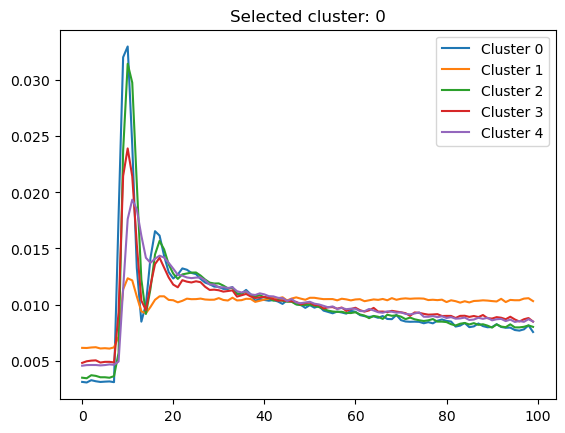

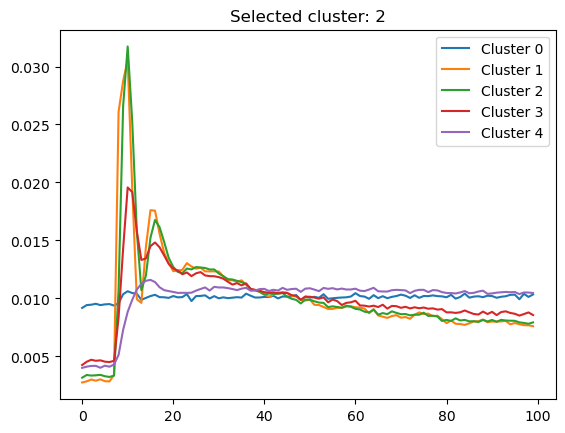

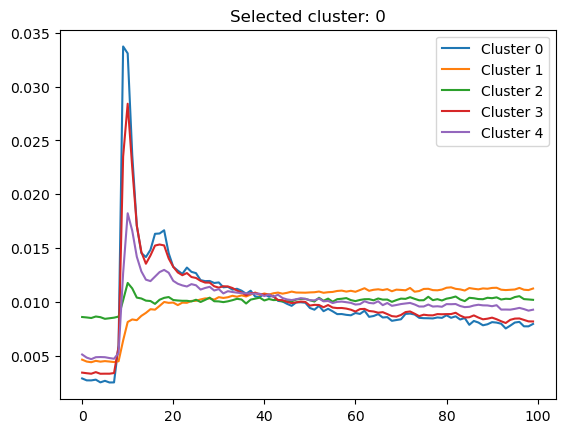

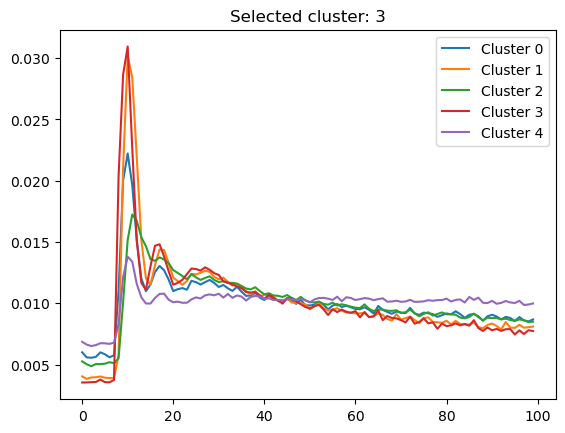

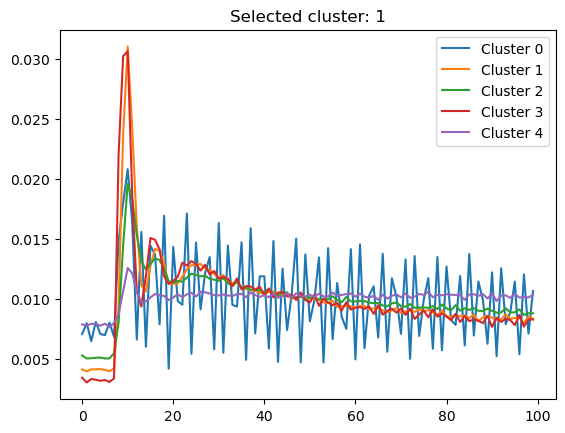

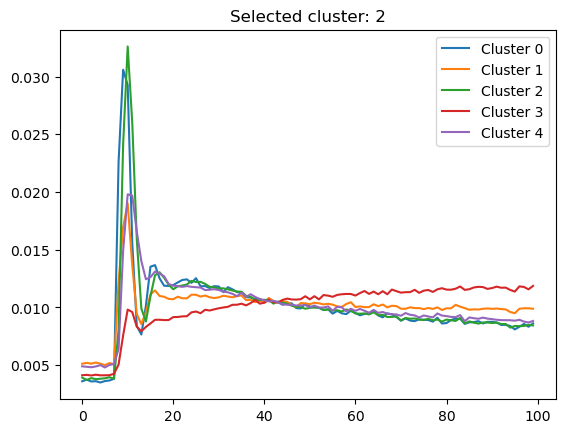

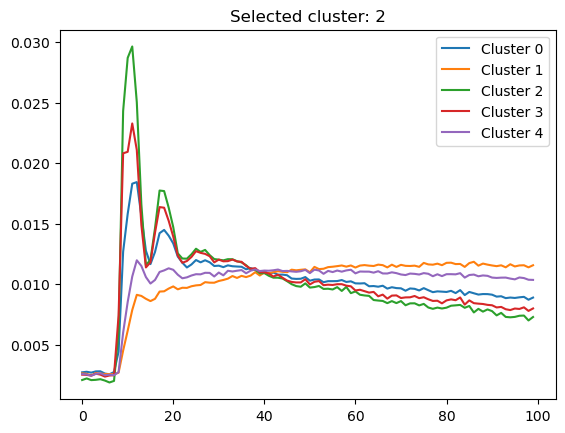

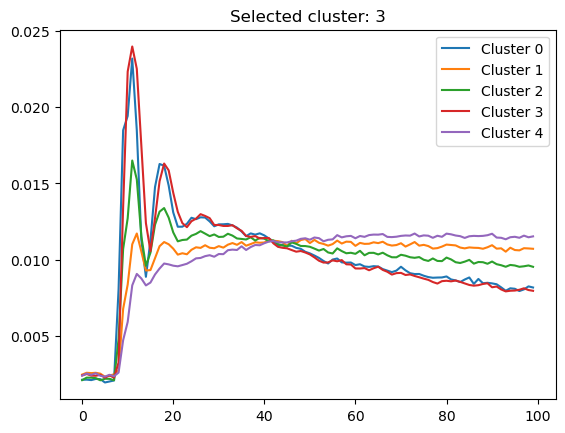

In [82]:
p, i = single_eval_curve(model, filtered_image_data, 4, intensities,
                         device, SEED, 0.7, True, 'sigmoid')


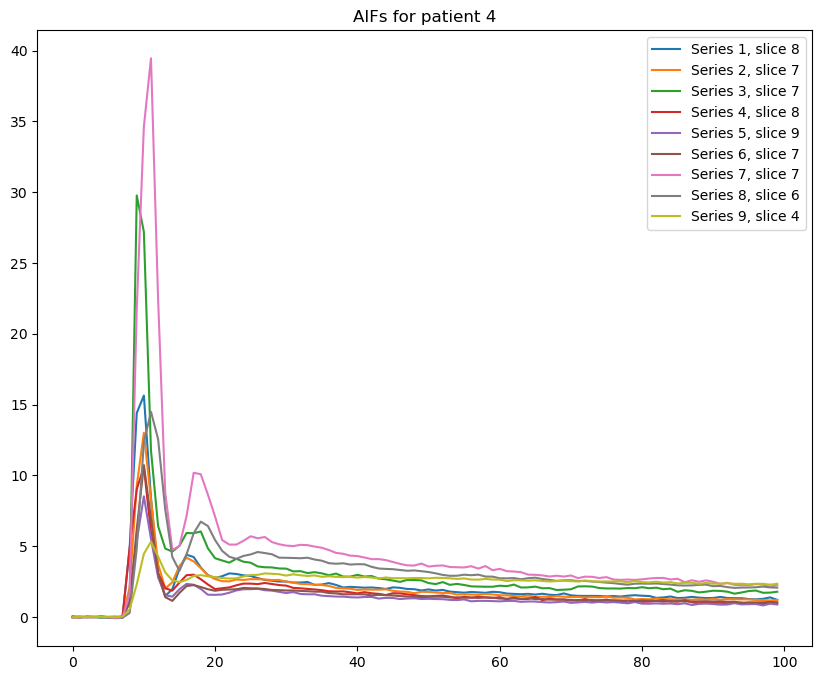

In [84]:
import matplotlib.pyplot as plt
from utils.model_utils import NLC_s2r
fig = plt.figure(figsize=(10, 8))

for series_key in list(p.keys()):
    for slice_key in list(p[series_key].keys()):
        curve = np.average(p[series_key][slice_key][0], axis=0)
        plt.plot(NLC_s2r(curve, i[series_key]['TR'], i[series_key]['FA']),
                 label=f"Series {series_key[1]}, slice {slice_key}")
plt.title(f"AIFs for patient {series_key[0]}")
plt.legend(loc='upper right')


In [9]:
from utils.model_utils import get_model_performance_metrics
train_sorted = get_model_performance_metrics(
    model, data, mca_labels, device, True, 0.7)
